In [2]:
import findspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder.appName('PM2.5 Shenyang').getOrCreate()

In [3]:
# Read from the data source
df = spark.read.csv('PMDataSets/ShenyangPM20100101_20151231.csv',header=True,inferSchema=True)

In [ ]:
df.printSchema()

In [ ]:
df.describe().toPandas().transpose()

In [ ]:
df.toPandas()

In [4]:
# Data Cleaning: Features Selection.
df_1 = df.drop('No','year','month','day','hour','season','PM_Taiyuanjie','PM_Xiaoheyan')
# Data Cleaning: Remove instances with 'NA' value.
df_2 = df_1.filter(df['PM_US Post']!='NA')
df_3 = df_2.filter(df['DEWP']!='NA')
df_4 = df_3.filter(df['HUMI']!='NA')
df_5 = df_4.filter(df['PRES']!='NA')
df_6 = df_5.filter(df['TEMP']!='NA')
df_7 = df_6.filter(df['cbwd']!='NA')
df_8 = df_7.filter(df['Iws']!='NA')
df_9 = df_8.filter(df['precipitation']!='NA')
df_10 = df_9.filter(df['Iprec']!='NA')
df_11 = df_10.filter(df['DEWP']!='-97.0')
df = df_11

In [ ]:
# This step shows the inconsistency of the data type.
df.printSchema()
df.describe().toPandas().transpose()

In [5]:
# Data Cleaning: Manually changing the data type.
df = df.withColumn('PM_US Post', df['PM_US Post'].cast("double"))
df = df.withColumn('DEWP', df['DEWP'].cast("double"))
df = df.withColumn('HUMI', df['HUMI'].cast("double"))
df = df.withColumn('PRES', df['PRES'].cast("double"))
df = df.withColumn('TEMP', df['TEMP'].cast("double"))
df = df.withColumn('Iws', df['Iws'].cast("double"))
df = df.withColumn('precipitation', df['precipitation'].cast("double"))
df = df.withColumn('Iprec', df['Iprec'].cast("double"))
df.printSchema()
df.describe().toPandas().transpose()

root
 |-- PM_US Post: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- HUMI: double (nullable = true)
 |-- PRES: double (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- Iprec: double (nullable = true)



,0,1,2,3,4
summary,count,mean,stddev,min,max
PM_US Post,20452,75.07559162918052,65.96112890480879,1.0,932.0
DEWP,20452,0.9533541951887345,13.059571890758495,-32.0,25.0
HUMI,20452,60.20907979659534,22.292088211418616,7.86,100.0
PRES,20452,1016.1516233131234,9.57588433561338,988.0,1042.0
TEMP,20452,9.399569724232348,12.960618813468997,-25.0,35.0
cbwd,20452,None,None,NE,cv
Iws,20452,22.291707412477997,38.84690318576528,0.0,465.0
precipitation,20452,0.05619499315470371,0.5445631947896592,0.0,23.9
Iprec,20452,0.2641159788773718,2.320982716538578,0.0,66.2


In [6]:
# Data Cleaning: New feature construction
def judgement(x):
    if (x>=0) & (x<75):
        return 0
    elif (x>=75) & (x<150):
        return 1
    else:
        return 2
udf_judgement = udf(judgement, IntegerType())
df = df.withColumn('Harm',udf_judgement(df['PM_US Post']))
def cbwd_vc(x):
    if x=='cv':
        return 0
    elif x=='SW':
        return 1
    elif x=='SE':
        return 2
    elif x=='NE':
        return 3
    else:
        return 4
udf_cbwd_vc = udf(cbwd_vc, IntegerType())
df = df.withColumn('cbwd',udf_cbwd_vc(df['cbwd']))
df.toPandas()

,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,Harm
0,113.0,-1.0,25.89,1013.0,19.0,1,55.0,0.0,0.0,1
1,74.0,-6.0,26.11,1012.0,13.0,1,12.0,0.0,0.0,0
2,59.0,-5.0,26.40,1012.0,14.0,1,17.0,0.0,0.0,0
3,69.0,-4.0,26.69,1011.0,15.0,1,23.0,0.0,0.0,0
4,78.0,-3.0,26.98,1010.0,16.0,1,31.0,0.0,0.0,1
5,101.0,-4.0,25.04,1010.0,16.0,1,38.0,0.0,0.0,1
6,96.0,0.0,35.87,1009.0,15.0,1,45.0,0.0,0.0,1
7,100.0,2.0,44.20,1009.0,14.0,1,51.0,0.0,0.0,1
8,106.0,2.0,50.36,1010.0,12.0,1,56.0,0.0,0.0,1
9,131.0,4.0,62.00,1010.0,11.0,1,61.0,0.0,0.0,1


In [7]:
# Data Transformation: Further reduction
df = df.drop('PM_US Post')
# Data Transformation: Correlation Check
print("DEWP-Harm Correlation:",df.corr('DEWP','Harm'))
print("HUMI-Harm Correlation:",df.corr('HUMI','Harm'))
print("PRES-Harm Correlation:",df.corr('PRES','Harm'))
print("TEMP-Harm Correlation:",df.corr('TEMP','Harm'))
print("cbwd-Harm Correlation:",df.corr('cbwd','Harm'))
print("Iws-Harm Correlation:",df.corr('Iws','Harm'))
print("Precipitation-Harm Correlation:",df.corr('precipitation','Harm'))
print("Iprec-Harm Correlation:",df.corr('Iprec','Harm'))

DEWP-Harm Correlation: -0.2443585209962297
HUMI-Harm Correlation: 0.1751697408343396
PRES-Harm Correlation: 0.36690086039662523
TEMP-Harm Correlation: -0.3505233250654914
cbwd-Harm Correlation: -0.058016728506481485
Iws-Harm Correlation: -0.0926955054070127
Precipitation-Harm Correlation: -0.04179278542735584
Iprec-Harm Correlation: -0.056250671319925484


In [8]:
# Data Transformation: Further reduction according to correlation
df = df.drop('precipitation','Iprec')
df.toPandas()

,DEWP,HUMI,PRES,TEMP,cbwd,Iws,Harm
0,-1.0,25.89,1013.0,19.0,1,55.0,1
1,-6.0,26.11,1012.0,13.0,1,12.0,0
2,-5.0,26.40,1012.0,14.0,1,17.0,0
3,-4.0,26.69,1011.0,15.0,1,23.0,0
4,-3.0,26.98,1010.0,16.0,1,31.0,1
5,-4.0,25.04,1010.0,16.0,1,38.0,1
6,0.0,35.87,1009.0,15.0,1,45.0,1
7,2.0,44.20,1009.0,14.0,1,51.0,1
8,2.0,50.36,1010.0,12.0,1,56.0,1
9,4.0,62.00,1010.0,11.0,1,61.0,1


In [ ]:
# Changing to pandas dataframe for Data Balancing: OverSampling
df_pandas = df.toPandas()
print(df_pandas['Harm'].value_counts())
df_0 = df_pandas[df_pandas['Harm'] == 0]
df_1 = df_pandas[df_pandas['Harm'] == 1]
df_2 = df_pandas[df_pandas['Harm'] == 2]
df_1_new = df_1.sample(frac=2,replace=True)
df_2_new = df_2.sample(frac=5, replace=True)
df_pandas = pd.concat([df_0, df_1_new, df_2_new], ignore_index=True)
df_pandas.sample(frac=1)
print(df_pandas['Harm'].value_counts())
df = spark.createDataFrame(df_pandas)
df.toPandas()        

In [9]:
# Preparing for machine learning
cbwd_Indexer = StringIndexer(inputCol = 'cbwd', outputCol = 'cbwdIndex')
cbwd_encoder = OneHotEncoder(inputCol = 'cbwdIndex', outputCol = 'cbwdVec')

Harm_Indexer = StringIndexer(inputCol = 'Harm', outputCol = 'label')

assembler = VectorAssembler(inputCols=['DEWP','HUMI','PRES','cbwdVec','TEMP','Iws'], outputCol="features")

In [10]:
# Pipeline
pipeline = Pipeline(stages=[cbwd_Indexer, Harm_Indexer, cbwd_encoder, assembler])
pipeline_model = pipeline.fit(df)
pipe_df = pipeline_model.transform(df)
pipe_df = pipe_df.select('label', 'features')
pipe_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
train_data, test_data = pipe_df.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label',impurity='gini')
dt_Model = dt.fit(train_data)
predictions = dt_Model.transform(test_data)
predictions.select("prediction", "label", "features").show(5)

In [11]:
# Randomforest Classifier
from pyspark.ml.classification import RandomForestClassifier
train_data, test_data = pipe_df.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',numTrees=30,  maxDepth = 6)
rf_Model = rf.fit(train_data)
predictions = rf_Model.transform(test_data)
predictions.select("prediction", "label", "features").show(10)

Training Dataset Count: 16309
Test Dataset Count: 4143
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(9,[0,1,2,7],[-18...|
|       0.0|  0.0|(9,[0,1,2,7],[-17...|
|       2.0|  0.0|(9,[0,1,2,7],[-17...|
|       0.0|  0.0|(9,[0,1,2,7],[-16...|
|       2.0|  0.0|(9,[0,1,2,7],[-15...|
|       0.0|  0.0|(9,[0,1,2,7],[-12...|
|       0.0|  0.0|(9,[0,1,2,7],[-11...|
|       0.0|  0.0|(9,[0,1,2,7],[1.0...|
|       0.0|  0.0|(9,[0,1,2,7],[2.0...|
|       0.0|  0.0|(9,[0,1,2,7],[6.0...|
+----------+-----+--------------------+
only showing top 10 rows



In [ ]:
# Evaluating Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

In [12]:
rf_Model.featureImportances

SparseVector(9, {0: 0.1196, 1: 0.1488, 2: 0.2726, 3: 0.0279, 4: 0.0483, 5: 0.113, 6: 0.0209, 7: 0.1907, 8: 0.0583})

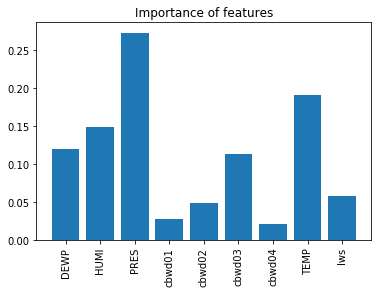

In [13]:
importances = rf_Model.featureImportances
plt.bar(['DEWP','HUMI','PRES','cbwd01','cbwd02','cbwd03','cbwd04','TEMP','Iws'],importances)
plt.title("Importance of features")
plt.xticks(rotation=90)
plt.show()

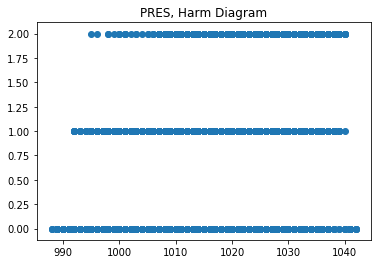

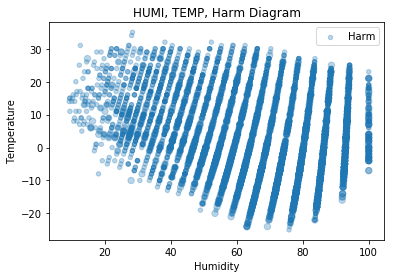

In [14]:
df_pandas = df.toPandas()
plt.scatter(df_pandas['PRES'],df_pandas['Harm'])
plt.title("PRES, Harm Diagram")
plt.show()

plt.scatter(df_pandas['HUMI'],df_pandas['TEMP'],df_pandas['Harm']*20, alpha=0.3)
plt.title("HUMI, TEMP, Harm Diagram")
plt.xlabel("Humidity")
plt.ylabel("Temperature")
plt.legend(["Harm"])
plt.show()